In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy
import matplotlib.pyplot as plt
import numpy as np
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalMaxPool1D, MaxPooling1D, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Hanna's data

In [0]:
import zipfile
with zipfile.ZipFile('./drive/My Drive/hackaton/wili-2018.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/Hackathon/'
wili_data_path = ''

x_train_path = wili_data_path + 'x_train.txt'
x_test_path = wili_data_path + 'x_test.txt'
y_train_path = wili_data_path + 'y_train.txt'
y_test_path = wili_data_path + 'y_test.txt'
labels_path = wili_data_path + 'labels.csv'

# Download data

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/Hackathon/'
wili_data_path = data_path + 'wili-2018/'

x_train_path = wili_data_path + 'x_train.txt'
x_test_path = wili_data_path + 'x_test.txt'
y_train_path = wili_data_path + 'y_train.txt'
y_test_path = wili_data_path + 'y_test.txt'
labels_path = wili_data_path + 'labels.csv'

In [45]:
labels = pd.read_csv(labels_path, sep=';')
labels = labels.drop(labels=['German', 'Writing system', 'Remarks', 'Synonyms'], axis=1)
labels

,Label,English,Wiki Code,ISO 369-3,Language family
0,ace,Achinese,ace,ace,Austronesian
1,afr,Afrikaans,af,afr,Indo-European
2,als,Alemannic German,als,gsw,Indo-European
3,amh,Amharic,am,amh,Afro-Asiatic
4,ang,Old English,ang,ang,Indo-European
...,...,...,...,...,...
230,yid,Yiddish,yi,yid,Indo-European
231,yor,Yoruba,yo,yor,Niger-Congo
232,zea,Zeeuws,zea,zea,Indo-European
233,zh-yue,Cantonese,zh-yue,NaN,Sino-Tibetan


In [0]:
class_to_language = labels.Label.astype(str).to_dict()
language_to_class = {v: k for k, v in class_to_language.items()}
num_classes = len(class_to_language)

In [50]:
print(list(language_to_class.items())[:5])
num_classes

[('ace', 0), ('afr', 1), ('als', 2), ('amh', 3), ('ang', 4)]


235

In [0]:
def read_data():
    with open(x_train_path) as f:
        mylist = f.read().splitlines() 
    x_train = pd.DataFrame(mylist, columns=["sent"])
    with open(x_test_path) as f:
        mylist = f.read().splitlines() 
    x_test = pd.DataFrame(mylist, columns=["sent"])

    with open(y_train_path) as f:
        mylist = f.read().splitlines() 
    y_train = []
    for lan in mylist:
        y_train.append(language_to_class[lan])
    y_train = pd.DataFrame(y_train)
    with open(y_test_path) as f:
        mylist = f.read().splitlines()

    y_test = []
    for lan in mylist:
        y_test.append(language_to_class[lan])
    y_test = pd.DataFrame(y_test)
    
    return (x_train, y_train), (x_test, y_test)

In [0]:
(x_train, y_train), (x_test, y_test) = read_data()

In [54]:
print(x_train.head())
print(y_train.head())

print(x_train.shape)
print(x_test.shape)

                                                sent
0  Klement Gottwaldi surnukeha palsameeriti ning ...
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...
3  Après lo cort periòde d'establiment a Basilèa,...
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...
     0
0   52
1  198
2  124
3  155
4  207
(117500, 1)
(117500, 1)


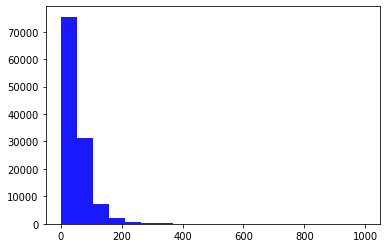

In [55]:
lens = x_train.sent.str.split(' ').str.len().values
plt.hist(lens, bins=np.linspace(0,1000,20), facecolor='blue', alpha=0.9)
plt.show()

# Experiment on small dataset

In [0]:
# small_dataset = pd.read_csv(data_path + 'kaggle_dataset/dataset.csv')
# small_dataset

In [0]:
# X=small_dataset['Text']
# y=small_dataset['language']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(len(X_train))
# print(len(X_test))
# print(len(y_train))
# print(len(y_test))

# Embedding **data**

In [0]:
filter_out = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
tokenizer = Tokenizer(filters=filter_out, lower=True)
tokenizer.fit_on_texts(x_train.sent)

Выбираю какое количество слов оставить. Если оставлять все, то будет 1500000, что слишком много. Можно поменять `count` и оно покажет сколько слов встречается больше, чем `count` раз

In [57]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 10
frequent_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(frequent_words)

64157

In [0]:
embed_size = 300 # how big is each word vector
max_features = len(frequent_words) # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters=filter_out, lower=True)

def prepare_data():
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1, stratify=y_train.values)
   
    tokenizer.fit_on_texts(x_tr.sent)

    train_X = tokenizer.texts_to_sequences(x_tr.sent)
    val_X = tokenizer.texts_to_sequences(x_val.sent)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)

    return (train_X, y_tr), (val_X, y_val)
    

In [0]:
(train_X, train_Y), (val_X, val_Y) = prepare_data()

Проверила, что в тренировочном и валидационном датасетах встречаются все классы. Балансировка регулируется вот этим параметром: stratify=y_train.values

In [60]:
len(set(val_Y.values.reshape(1, -1)[0]))

235

In [61]:
len(set(train_Y.values.reshape(1, -1)[0]))

235

Ниже меняю представление векторов ответов из [1, 23, 10,...] в вектор длины 235 и с 1 на месте соответсвующего языка

In [62]:
lb = LabelEncoder()
y = lb.fit_transform(train_Y.values)
dummy_y_train = to_categorical(y)
print(len(dummy_y_train))
print(len(dummy_y_train[0]))

105750
235


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
y = lb.fit_transform(val_Y.values)
dummy_y_val = to_categorical(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Metrics

In [0]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [0]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

#CNN

In [68]:
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, embed_size,input_shape=(maxlen,)))
cnn_model.add(Conv1D(256, 5, activation='relu', input_shape=(embed_size,)))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(256, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          19247100  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 256)          384256    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)             

In [0]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])

In [0]:
cnn_cp_path = data_path+'model_cnn.hdf5'
cnn_cp=ModelCheckpoint(cnn_cp_path, monitor='val_f1',save_best_only=True)

In [104]:
cnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=5, 
              validation_data=(val_X, dummy_y_val),
              callbacks = [cnn_cp]
             )

Epoch 1/5
 51/207 [======>.......................] - ETA: 1:01 - loss: 0.1227 - accuracy: 0.9635 - pres: 0.8565 - rec: 0.8453 - met: 0.8480 - recall: 0.9564 - precision: 0.9917

KeyboardInterrupt: ignored

In [0]:
dependencies = {
     'f1': f1,
     'recall': recall,
     'precision': precision
}

In [0]:
# cnn_model = load_model(cnn_cp_path, custom_objects=dependencies)

#RNN

In [0]:
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, embed_size))
rnn_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh',input_dim=embed_size)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh')))
rnn_model.add(GlobalMaxPool1D())
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(512, activation="relu"))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(num_classes, activation='softmax'))
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         19247100  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         1140736   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [0]:
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])

In [0]:
rnn_cp_path = data_path + 'model_rnn.hdf5'
rnn_cp=ModelCheckpoint(rnn_cp_path,monitor='val_f1',save_best_only=True)

In [0]:
# rnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=3, 
#               validation_data=(val_X, dummy_y_val), callbacks = [rnn_cp])

In [0]:
rnn_model = load_model(rnn_cp_path, custom_objects=dependencies)

# Results

In [0]:
x_test['sc'] = y_test
x_train['sc'] = y_train

In [0]:
# Be careful! Tokenizer and maxlen is taken from train dataset from 1st part
def convert(x):
    train_X = tokenizer.texts_to_sequences(x.sent)
    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    return train_X

In [0]:
def metr(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return precision, recall, f1_val

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return max(p), max(r), max(f1)

In [0]:
# New metric!
def met(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)), axis=0)
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)), axis=0)
    precision = max(true_positives / (true_positives + false_positives  + K.epsilon()))
    recall = max(true_positives / (true_positives + false_negatives  + K.epsilon()))
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return precision, recall, f1

# Test

In [0]:
ps = []
rs = []
fs = []
for lan in range(num_classes):
    x_t = x_test[x_test['sc'] == lan]
    x = convert(x_t)
    y = np.zeros((x.shape[0], num_classes))
    y[:, lan] = 1
    y = y.astype('float32')
    y_pred = cnn_model.predict(x)
    p, r, f = met(y, y_pred)
    ps.append(p.numpy())
    rs.append(r.numpy())
    fs.append(f.numpy())
    #print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

In [0]:
raw_metrics = pd.DataFrame(
    {'precision': ps,
     'recall': rs,
     'f1': fs
    })

In [0]:
metrics = raw_metrics.rename(class_to_language, axis='index')

In [82]:
print(metrics.head())

     precision  recall        f1
ace        1.0   0.980  0.989899
afr        1.0   0.976  0.987854
als        1.0   0.734  0.846597
amh        1.0   0.986  0.992951
ang        1.0   0.918  0.957247


In [87]:
bad_quality_metrics = metrics[metrics.recall < 0.7]
bad_quality_metrics

,precision,recall,f1
bel,1.0,0.490,0.657718
bod,1.0,0.166,0.284734
bos,1.0,0.540,0.701299
eng,1.0,0.546,0.706339
hbs,1.0,0.548,0.708010
hrv,1.0,0.592,0.743719
jpn,1.0,0.126,0.223801
khm,1.0,0.416,0.587571
lao,1.0,0.570,0.726115
lzh,0.0,0.000,0.000000


In [93]:
lab = labels.set_index('Label')
bad_quality_labels = lab.loc[bad_quality_metrics.index]
bad_quality_labels

,English,Wiki Code,ISO 369-3,Language family
bel,Belarusian,be,bel,Indo-European
bod,Tibetan,bo,bod,Sino-Tibetan
bos,Bosnian,bs,bos,Indo-European
eng,English,en,eng,Indo-European
hbs,Serbo-Croatian,sh,hbs,Indo-European
hrv,Croatian,hr,hrv,Indo-European
jpn,Japanese,ja,jpn,Japonic
khm,Central Khmer,km,khm,Austronesian
lao,Lao,lo,lao,Tai-Kadai
lzh,Literary Chinese,zh-classical,lzh,Sino-Tibetan


In [0]:
print(x_train[x_train.sc == language_to_class['wuu']])
print(x_train[x_train.sc == language_to_class['lzh']])

                                                     sent   sc
19      UNC有得一只历史悠久个'诚信守则'。渠是由学堂个诚信法庭（Honor Court）来执行个...  187
276     武器，是人类为达到杀伤或者防御个目的制造个器械。武器从人类文明发展开始就有出现，之后，伴随战...  187
387     弗过，太后个信任是一方面，具体西班牙个政治局面又是另外一番情形：贵族对迭个外国人一点也无信任...  187
720     从12世纪挨末阶段开始，日本个统治权就转移到日本武士贵族个手里向。到13世纪，出身清和源氏个...  187
930     箇种毛病潜伏期一般勒7日天以内，病人一般表现为流感箇浪个症状，像发寒热，咳嗽，少痰，有种辰光...  187
...                                                   ...  ...
116805  Linux個低成本、強大個定制功能搭良好個移植性能，使得Linux來嵌入式系統方面也得到廣泛...  187
116947  余杭區勒拉杭嘉湖平原南端，西依天目山，南瀕錢塘江，是長江三角洲个圓心地。地理座標爲北緯30°...  187
117034  北師大是以京師大學堂師範專業做基礎，搭仔由北京個高校匯聚一批勒師範教育領域窮有聲望個名師組建...  187
117037  到清中期（約18世紀），傳奇開始衰微，向書齋文學轉化，彈詞卻逐步興盛起來了。出版之錢德蒼編个...  187
117257  摩嘉娜夺权计划失败后，带领奄奄一息个莫高絲逃出卡美洛特，徕萨温节夜里，摩嘉娜徕莫高絲个要求之...  187

[500 rows x 2 columns]
                                                     sent  sc
336     武漢市，亦稱以漢，乃中華鄂省之會，亦為七大都市於中華之中原也。方八千四百六十七公里，於西元二...  97
420     按黃帝為法，數有十等。及其用也，乃有三焉。十等者，謂「億、兆、京、垓、秭、壤、溝、澗、正、載...  97
1254    范蠡浮海出齊，變姓名，自謂鴟夷子皮，耕於海畔，苦身戮

# Fix Chinese langs

In [0]:
# Extract Unigrams
from sklearn.feature_extraction.text import CountVectorizer
unigramVectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1))
X_unigram_train_raw = unigramVectorizer.fit_transform(x_train)
X_unigram_test_raw = unigramVectorizer.transform(x_test)


unigramFeatures = unigramVectorizer.get_feature_names()

print('Number of unigrams in training set:', len(unigramFeatures))

Number of unigrams in training set: 4


In [0]:
def train_lang_dict(X_raw_counts, y_train):
    lang_dict = {}
    for i in range(len(y_train)):
        lang = y_train[i]
        v = np.array(X_raw_counts[i])
        if not lang in lang_dict:
            lang_dict[lang] = v
        else:
            lang_dict[lang] += v
            
    # to relative
    for lang in lang_dict:
        v = lang_dict[lang]
        lang_dict[lang] = v / np.sum(v)
        
    return lang_dict

language_dict_unigram = train_lang_dict(X_unigram_train_raw.toarray(), y_train.values)

# Collect relevant chars per language
def getRelevantCharsPerLanguage(features, language_dict, significance=1e-5):
    relevantCharsPerLanguage = {}
    for lang in languages:
        chars = []
        relevantCharsPerLanguage[lang] = chars
        v = language_dict[lang]
        for i in range(len(v)):
            if v[i] > significance:
                chars.append(features[i])
    return relevantCharsPerLanguage

relevantCharsPerLanguage = getRelevantCharsPerLanguage(unigramFeatures, language_dict_unigram)
    
# Print number of unigrams per language
for lang in languages:    
    print(lang, len(relevantCharsPerLanguage[lang]))

TypeError: ignored